In [1]:
import numpy as np
import pandas as pd
import rasterio
import os
import glob
import skimage.io
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import argparse
import gc
import random
# import imgaug as ia
# import imgaug.augmenters as iaa

In [2]:
def load_RGB_images(ID, load_extra=False):
  # e.g id_0b242e06 -> 0b242e06
  if load_extra:
    extra = 'extra_train-'
  else:
    extra = ''
  name = ID.split('_')[1]
  img_jun17 = skimage.io.imread(f'../input/lacuna-unzipped/data/{extra}planet-jun17/{name}.png')
  img_dec17 = skimage.io.imread(f'../input/lacuna-unzipped/data/{extra}planet-dec17/{name}.png')
  img_jun18 = skimage.io.imread(f'../input/lacuna-unzipped/data/{extra}planet-jun18/{name}.png')
  img_dec18 = skimage.io.imread(f'../input/lacuna-unzipped/data/{extra}planet-dec18/{name}.png')
  return [img_jun17, img_dec17, img_jun18, img_dec18]
  # return img_dec18

def load_Spectral_image(ID, load_extra=False, year_2015=False):
  # e.g id_0b242e06 -> 0b242e06
  if load_extra:
    extra = 'extra_train-'
  else:
    extra = ''
  name = ID.split('_')[1]
  if year_2015:
    root_dir = 'sentinel_for_points_collected_in_2015'
  else:
    root_dir = extra + 'sentinel'
  img_sentinel = skimage.io.imread(f'../input/lacuna-unzipped/data/{root_dir}/{name}.tif')
  return img_sentinel


def padding_sentinel(array, xx=41, yy=41):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """
    h = min(41, array.shape[0])
    w = min(41, array.shape[1])

    a = (xx - h) // 2
    aa = xx - a - h

    b = (yy - w) // 2
    bb = yy - b - w

    array_zeros = np.zeros((xx, yy, 192))
    array_zeros[a:a+h, b:b+w, :] = array[0:0+h, 0:0+w, :]
    
    return array_zeros

def padding(array, xx=84, yy=84):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]

    a = (xx - h) // 2
    aa = xx - a - h

    b = (yy - w) // 2
    bb = yy - b - w

    array_zeros = np.zeros((xx, yy, 3))
    array_zeros[a:a+h, b:b+w, :] = array
    
    return array_zeros

In [3]:
def clean():
    torch.cuda.empty_cache()
    gc.collect()

In [4]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    

In [31]:

CONST_X = 10.986328125 / 2
CONST_Y = 10.985731758 / 2

class MyDataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, train=True, transform=None, test=False, load_sentinel=False):

        self.test = test
        self.train = train
        self.load_sentinel = load_sentinel

        if not test:
            self.df1 = pd.read_csv('../input/lacuna-data-download/train-unique.csv')
            self.df1['unique'] = False
            self.df2 = pd.read_csv('../input/lacuna-data-download/extra_train.csv')
            self.df2['unique'] = True
            self.df = pd.concat([self.df1, self.df2], ignore_index=True).sample(frac=1, random_state=0)
            
            if train:
                np.random.seed(0)
                msk = np.random.rand(len(self.df)) < 0.8
            else:
                np.random.seed(0)
                msk = np.random.rand(len(self.df)) >= 0.8
            self.df = self.df[msk]
#             if train:
#                 p2 = '../input/lacuna-data-download/auxilary_data-unique.csv'
#                 new_df = pd.read_csv(p2)
#                 new_df['unique'] = False
#                 self.df = pd.concat([self.df, new_df], ignore_index=True)
        else:
            self.df = pd.read_csv('../input/lacuna-data-download/test.csv')
            self.df['unique'] = False


        self.transform = transform

#         if self.transform is None:
#           self.transform = transforms.Compose(
#             [transforms.ToTensor(),
#             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = self.df.iloc[idx, 0]
        
        output = np.zeros((84, 84))
        output_reg = np.zeros((2, 84, 84))

        if not self.test:
            x = self.df.iloc[idx, 5]
            y = self.df.iloc[idx, 6]

        images = load_RGB_images(img_id, load_extra=self.df.iloc[idx, -1])
        for i in range(4):
          images[i] = images[i]/255.
          images[i] = padding(images[i])
            
          images[i][0:42-10, :] = 0
          images[i][42+10:, :] = 0
          images[i][:, 0:42-10] = 0
          images[i][:, 42+10:] = 0
            
          images[i] = images[i][42-10:42+10, 42-10:42+10]

        
        
        fliplr = False
        flipud = False
        if self.train and not self.test:
            if np.random.rand() >= 0.5:
                fliplr = True
            if np.random.rand() >= 0.5:
                flipud = True
            
        if fliplr:
            for i in range(4):
                images[i] = np.fliplr(images[i])
            x *= -1
        if flipud:
            for i in range(4):
                images[i] = np.flipud(images[i])
            y *= -1
            
        images = np.dstack(images)
        images = images[:, :, 0:3]
        
        
        if not self.test:
            x0, y0 = 84//2, 84//2
#             x1 = x0 - np.round(x / CONST_X * images[0].shape[1])
#             y1 = y0 + np.round(y / CONST_Y * images[0].shape[0])
            x1 = x0 - x / CONST_X * images[0].shape[1]
            y1 = y0 + y / CONST_Y * images[0].shape[0]
            output[int(y1), int(x1)] = 1
            output_reg[0, int(y1), int(x1)] = y1 - int(y1)
            output_reg[1, int(y1), int(x1)] = x1 - int(x1)

        if self.load_sentinel:
            load_2015 = (int(self.df.iloc[idx, 1])==2015)
            if self.test:
              load_2015 = False
            sentinel_image = load_Spectral_image(img_id, 
                                                load_extra=self.df.iloc[idx, -1], 
                                                year_2015=load_2015)
            sentinel_image = sentinel_image / 20000.
            sentinel_image = padding_sentinel(sentinel_image)
            images = [images, sentinel_image]


        if self.test:
            ys = img_id
        else:
#             ys = output, output_reg
            ys = np.array([x, y])

        return images, ys

In [42]:

class Net(nn.Module):

    def __init__(self, sentinel=False):
        super(Net, self).__init__()

        self.sentinel = sentinel
        
        self.model1 = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
        )
            
        self.model2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),

            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
        )
            
        self.model3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
        )
            
  
        self.fc1 = nn.Sequential(
            nn.Linear(256*5*5, 256),
            nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(inplace=True)
        )
        self.fc3 = nn.Linear(256, 2)
        
    def forward(self, xs):
        feats0 = xs
        feats1 = self.model1(feats0)
        feats2 = self.model2(feats1)
        
        feats3 = self.model3(feats2)
        
        feats3 = feats3 + feats2
        feats = feats3
        feats = torch.flatten(feats, start_dim=1)
        feats = self.fc1(feats)
        feats = self.fc2(feats)
        feats = self.fc3(feats)
        return feats



In [43]:
def train(epochs=10, sentinel=False, model_type='resnet'):

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  seed_everything(seed=10)

  net = Net(sentinel=sentinel)
  
  net = net.double()
  net = net.to(device)
  
  criterion = nn.L1Loss()
  optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
  lrs = []

  dataset = MyDataset(load_sentinel=sentinel)
  data_loader = torch.utils.data.DataLoader(dataset, batch_size=16)

  val_dataset = MyDataset(train=False, load_sentinel=sentinel)
  val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16)

  writer = SummaryWriter(log_dir='/content/logs')

  step = 0
  best_loss = 10000
  for epoch in range(epochs):  # loop over the dataset multiple times
      print('Start epoch', epoch)
      print("Factor = ",0.9," , Learning Rate = ",optimizer.param_groups[0]["lr"])
      net.train()
      running_loss = 0.0
      train_losses = []
      train_losses_cls = []
      train_losses_reg = []
      for i, data in enumerate(tqdm(data_loader)):
        
          images, labels_reg = data
                      
          if sentinel:
            images[0] = images[0].permute(0, 3, 1, 2)
            images[1] = images[1].permute(0, 3, 1, 2)
          else:
            images = images.permute(0, 3, 1, 2)

          if sentinel:
            images[0] = images[0].to(device)
            images[1] = images[1].to(device)
          else:
            images = images.to(device)
            
          labels_reg = labels_reg.to(device)
          
          optimizer.zero_grad()
          outputs = net(images)

          loss = criterion(outputs, labels_reg)
         
          train_losses.append(loss.item())
          loss.backward()
          optimizer.step()

          step += 1
          writer.add_scalar("train/loss", loss, global_step=step)
      writer.flush()
      scheduler.step()
      print('Train loss = ', np.mean(np.array(train_losses)))
      net.eval()
      eval_losses = []
      eval_losses_cls = []
      eval_losses_reg = []
      for i, data in enumerate(tqdm(val_data_loader)):
        
          images, labels_reg = data
          if sentinel:
            images[0] = images[0].permute(0, 3, 1, 2)
            images[1] = images[1].permute(0, 3, 1, 2)
          else:
            images = images.permute(0, 3, 1, 2)
          if sentinel:
            images[0] = images[0].to(device)
            images[1] = images[1].to(device)
          else:
            images = images.to(device)
          labels_reg = labels_reg.to(device)

          outputs = net(images)
          loss = criterion(outputs, labels_reg)
        
          eval_losses.append(loss.item())
      writer.add_scalar("val/loss", np.mean(np.array(eval_losses)), global_step=epoch)
      writer.flush()
      print('Val loss = ', np.mean(np.array(eval_losses)))
      if np.mean(np.array(eval_losses)) < best_loss:
        print('saving the best model')
        best_loss = np.mean(np.array(eval_losses))
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
          }, './model_best.pth')

  writer.close()
          
  torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
          }, './model.pth')

  print('Finished Training')

In [44]:
clean()

In [45]:
train(epochs=60, sentinel=False)

  1%|▏         | 1/68 [00:00<00:09,  7.10it/s]

Start epoch 0
Factor =  0.9  , Learning Rate =  0.0003


  6%|▌         | 1/18 [00:00<00:02,  7.71it/s]

Train loss =  0.24413130928323679


100%|██████████| 18/18 [00:02<00:00,  7.80it/s]


Val loss =  0.22576887277734187
saving the best model


  1%|▏         | 1/68 [00:00<00:09,  6.89it/s]

Start epoch 1
Factor =  0.9  , Learning Rate =  0.00027


  6%|▌         | 1/18 [00:00<00:01,  8.55it/s]

Train loss =  0.2334444343716173


  1%|▏         | 1/68 [00:00<00:09,  7.04it/s]

Val loss =  0.23486371516844898
Start epoch 2
Factor =  0.9  , Learning Rate =  0.000243


  6%|▌         | 1/18 [00:00<00:01,  9.04it/s]

Train loss =  0.22607985898799185


  1%|▏         | 1/68 [00:00<00:09,  6.81it/s]

Val loss =  0.22698811926108423
Start epoch 3
Factor =  0.9  , Learning Rate =  0.0002187


  6%|▌         | 1/18 [00:00<00:01,  8.71it/s]

Train loss =  0.22512950688547592


100%|██████████| 18/18 [00:02<00:00,  7.95it/s]


Val loss =  0.22356900793981233
saving the best model


  1%|▏         | 1/68 [00:00<00:09,  6.87it/s]

Start epoch 4
Factor =  0.9  , Learning Rate =  0.00019683


  6%|▌         | 1/18 [00:00<00:01,  8.96it/s]

Train loss =  0.22548133896981026


100%|██████████| 18/18 [00:01<00:00,  9.07it/s]


Val loss =  0.22265903812145504
saving the best model


  1%|▏         | 1/68 [00:00<00:09,  6.77it/s]

Start epoch 5
Factor =  0.9  , Learning Rate =  0.000177147


  6%|▌         | 1/18 [00:00<00:01,  8.58it/s]

Train loss =  0.22444071540195362


  1%|▏         | 1/68 [00:00<00:10,  6.44it/s]

Val loss =  0.2287784818013826
Start epoch 6
Factor =  0.9  , Learning Rate =  0.0001594323


  6%|▌         | 1/18 [00:00<00:01,  8.78it/s]

Train loss =  0.2227928271008774


100%|██████████| 18/18 [00:02<00:00,  8.74it/s]


Val loss =  0.22255024981036822
saving the best model


  1%|▏         | 1/68 [00:00<00:09,  6.94it/s]

Start epoch 7
Factor =  0.9  , Learning Rate =  0.00014348907


  6%|▌         | 1/18 [00:00<00:01,  8.90it/s]

Train loss =  0.22351787840865156


  1%|▏         | 1/68 [00:00<00:09,  7.03it/s]

Val loss =  0.2239667118270109
Start epoch 8
Factor =  0.9  , Learning Rate =  0.000129140163


  6%|▌         | 1/18 [00:00<00:02,  5.81it/s]

Train loss =  0.22212789762784294


100%|██████████| 18/18 [00:02<00:00,  7.56it/s]


Val loss =  0.22109042733022943
saving the best model


  1%|▏         | 1/68 [00:00<00:10,  6.13it/s]

Start epoch 9
Factor =  0.9  , Learning Rate =  0.0001162261467


  6%|▌         | 1/18 [00:00<00:01,  8.62it/s]

Train loss =  0.22429498078128246


100%|██████████| 18/18 [00:02<00:00,  8.57it/s]


Val loss =  0.2202498827860047
saving the best model


  1%|▏         | 1/68 [00:00<00:09,  7.02it/s]

Start epoch 10
Factor =  0.9  , Learning Rate =  0.00010460353203


  6%|▌         | 1/18 [00:00<00:01,  8.94it/s]

Train loss =  0.2220016895704955


  1%|▏         | 1/68 [00:00<00:09,  6.84it/s]

Val loss =  0.2212814173236116
Start epoch 11
Factor =  0.9  , Learning Rate =  9.4143178827e-05


  6%|▌         | 1/18 [00:00<00:02,  5.82it/s]

Train loss =  0.22298621065841023


  1%|▏         | 1/68 [00:00<00:09,  6.82it/s]

Val loss =  0.2225811429542347
Start epoch 12
Factor =  0.9  , Learning Rate =  8.47288609443e-05


  6%|▌         | 1/18 [00:00<00:01,  9.19it/s]

Train loss =  0.22091091754142955


  1%|▏         | 1/68 [00:00<00:09,  6.91it/s]

Val loss =  0.2209343841690434
Start epoch 13
Factor =  0.9  , Learning Rate =  7.625597484987e-05


  6%|▌         | 1/18 [00:00<00:01,  9.00it/s]

Train loss =  0.22065474616301217


  1%|▏         | 1/68 [00:00<00:09,  6.96it/s]

Val loss =  0.2239387139299308
Start epoch 14
Factor =  0.9  , Learning Rate =  6.8630377364883e-05


  6%|▌         | 1/18 [00:00<00:01,  8.95it/s]

Train loss =  0.2219329793388231


  1%|▏         | 1/68 [00:00<00:09,  6.99it/s]

Val loss =  0.22316246364320444
Start epoch 15
Factor =  0.9  , Learning Rate =  6.176733962839471e-05


  6%|▌         | 1/18 [00:00<00:02,  7.36it/s]

Train loss =  0.22111318142125533


  1%|▏         | 1/68 [00:00<00:09,  6.91it/s]

Val loss =  0.22235590017824533
Start epoch 16
Factor =  0.9  , Learning Rate =  5.559060566555524e-05


  6%|▌         | 1/18 [00:00<00:01,  9.24it/s]

Train loss =  0.22048814094843905


  1%|▏         | 1/68 [00:00<00:09,  6.89it/s]

Val loss =  0.22242770277453885
Start epoch 17
Factor =  0.9  , Learning Rate =  5.003154509899972e-05


  6%|▌         | 1/18 [00:00<00:01,  8.76it/s]

Train loss =  0.2208202081525773


100%|██████████| 18/18 [00:02<00:00,  8.90it/s]


Val loss =  0.21881063333580147
saving the best model


  1%|▏         | 1/68 [00:00<00:09,  6.90it/s]

Start epoch 18
Factor =  0.9  , Learning Rate =  4.502839058909975e-05


  6%|▌         | 1/18 [00:00<00:01,  8.99it/s]

Train loss =  0.22022269755343504


  1%|▏         | 1/68 [00:00<00:10,  6.43it/s]

Val loss =  0.21986777857269482
Start epoch 19
Factor =  0.9  , Learning Rate =  4.052555153018977e-05


  6%|▌         | 1/18 [00:00<00:01,  9.00it/s]

Train loss =  0.21847193883645205


  1%|▏         | 1/68 [00:00<00:09,  6.93it/s]

Val loss =  0.22062100179976904
Start epoch 20
Factor =  0.9  , Learning Rate =  3.64729963771708e-05


  6%|▌         | 1/18 [00:00<00:01,  9.35it/s]

Train loss =  0.21917529395658408


  1%|▏         | 1/68 [00:00<00:09,  7.11it/s]

Val loss =  0.22111878446114386
Start epoch 21
Factor =  0.9  , Learning Rate =  3.282569673945372e-05


  6%|▌         | 1/18 [00:00<00:01,  9.05it/s]

Train loss =  0.21876993674981343


  1%|▏         | 1/68 [00:00<00:10,  6.37it/s]

Val loss =  0.2189421648102723
Start epoch 22
Factor =  0.9  , Learning Rate =  2.9543127065508348e-05


  6%|▌         | 1/18 [00:00<00:01,  9.01it/s]

Train loss =  0.21730287339633148


  1%|▏         | 1/68 [00:00<00:09,  7.11it/s]

Val loss =  0.22000695659518618
Start epoch 23
Factor =  0.9  , Learning Rate =  2.6588814358957513e-05


  6%|▌         | 1/18 [00:00<00:01,  9.09it/s]

Train loss =  0.21918286755718575


100%|██████████| 18/18 [00:01<00:00,  9.07it/s]


Val loss =  0.218268367517209
saving the best model


  1%|▏         | 1/68 [00:00<00:09,  6.87it/s]

Start epoch 24
Factor =  0.9  , Learning Rate =  2.392993292306176e-05


  6%|▌         | 1/18 [00:00<00:02,  6.05it/s]

Train loss =  0.21772156464125358


  1%|▏         | 1/68 [00:00<00:09,  6.96it/s]

Val loss =  0.2197493218237685
Start epoch 25
Factor =  0.9  , Learning Rate =  2.1536939630755587e-05


  6%|▌         | 1/18 [00:00<00:01,  8.98it/s]

Train loss =  0.21819848999017144


  1%|▏         | 1/68 [00:00<00:09,  6.92it/s]

Val loss =  0.21874463835630498
Start epoch 26
Factor =  0.9  , Learning Rate =  1.938324566768003e-05


  6%|▌         | 1/18 [00:00<00:01,  9.09it/s]

Train loss =  0.21675365655897905


  1%|▏         | 1/68 [00:00<00:09,  6.91it/s]

Val loss =  0.2191018954564831
Start epoch 27
Factor =  0.9  , Learning Rate =  1.7444921100912026e-05


  6%|▌         | 1/18 [00:00<00:01,  8.87it/s]

Train loss =  0.2169258201161534


  1%|▏         | 1/68 [00:00<00:09,  6.76it/s]

Val loss =  0.21860825784399626
Start epoch 28
Factor =  0.9  , Learning Rate =  1.5700428990820825e-05


  6%|▌         | 1/18 [00:00<00:01,  8.61it/s]

Train loss =  0.21655490102354283


  1%|▏         | 1/68 [00:00<00:09,  6.93it/s]

Val loss =  0.22127257405763215
Start epoch 29
Factor =  0.9  , Learning Rate =  1.4130386091738743e-05


  6%|▌         | 1/18 [00:00<00:01,  8.86it/s]

Train loss =  0.2169997784911423


  1%|▏         | 1/68 [00:00<00:09,  6.82it/s]

Val loss =  0.21985082134170794
Start epoch 30
Factor =  0.9  , Learning Rate =  1.271734748256487e-05


  6%|▌         | 1/18 [00:00<00:01,  8.95it/s]

Train loss =  0.2156366181615697


  1%|▏         | 1/68 [00:00<00:09,  6.95it/s]

Val loss =  0.21903016717754706
Start epoch 31
Factor =  0.9  , Learning Rate =  1.1445612734308383e-05


  6%|▌         | 1/18 [00:00<00:01,  8.87it/s]

Train loss =  0.2165497483721218


  1%|▏         | 1/68 [00:00<00:09,  6.94it/s]

Val loss =  0.21900932346980762
Start epoch 32
Factor =  0.9  , Learning Rate =  1.0301051460877545e-05


  6%|▌         | 1/18 [00:00<00:01,  9.03it/s]

Train loss =  0.21555378385367893


  1%|▏         | 1/68 [00:00<00:10,  6.67it/s]

Val loss =  0.21887046163096596
Start epoch 33
Factor =  0.9  , Learning Rate =  9.27094631478979e-06


  6%|▌         | 1/18 [00:00<00:01,  9.09it/s]

Train loss =  0.2149937472241862


  1%|▏         | 1/68 [00:00<00:09,  7.16it/s]

Val loss =  0.22007893511650178
Start epoch 34
Factor =  0.9  , Learning Rate =  8.343851683310812e-06


  6%|▌         | 1/18 [00:00<00:01,  9.11it/s]

Train loss =  0.21529737403975183


  1%|▏         | 1/68 [00:00<00:09,  6.95it/s]

Val loss =  0.21911832649667695
Start epoch 35
Factor =  0.9  , Learning Rate =  7.509466514979731e-06


  6%|▌         | 1/18 [00:00<00:01,  8.75it/s]

Train loss =  0.2160387250970043


  1%|▏         | 1/68 [00:00<00:09,  7.07it/s]

Val loss =  0.21860176152718716
Start epoch 36
Factor =  0.9  , Learning Rate =  6.758519863481758e-06


  6%|▌         | 1/18 [00:00<00:01,  8.98it/s]

Train loss =  0.21446975278106126


  1%|▏         | 1/68 [00:00<00:09,  6.94it/s]

Val loss =  0.21899124819734872
Start epoch 37
Factor =  0.9  , Learning Rate =  6.082667877133583e-06


  6%|▌         | 1/18 [00:00<00:02,  6.32it/s]

Train loss =  0.2137590980501993


  1%|▏         | 1/68 [00:00<00:09,  6.75it/s]

Val loss =  0.2189331118216257
Start epoch 38
Factor =  0.9  , Learning Rate =  5.4744010894202246e-06


  6%|▌         | 1/18 [00:00<00:01,  8.99it/s]

Train loss =  0.21497667031325035


  1%|▏         | 1/68 [00:00<00:09,  7.08it/s]

Val loss =  0.21924219095440745
Start epoch 39
Factor =  0.9  , Learning Rate =  4.9269609804782025e-06


  6%|▌         | 1/18 [00:00<00:01,  9.03it/s]

Train loss =  0.21519541815280852


  1%|▏         | 1/68 [00:00<00:09,  7.02it/s]

Val loss =  0.21913453433242114
Start epoch 40
Factor =  0.9  , Learning Rate =  4.434264882430382e-06


  6%|▌         | 1/18 [00:00<00:01,  8.52it/s]

Train loss =  0.21528797385270115


  1%|▏         | 1/68 [00:00<00:09,  6.94it/s]

Val loss =  0.21918093351160248
Start epoch 41
Factor =  0.9  , Learning Rate =  3.990838394187344e-06


  6%|▌         | 1/18 [00:00<00:01,  9.15it/s]

Train loss =  0.214008315896803


  1%|▏         | 1/68 [00:00<00:09,  7.10it/s]

Val loss =  0.21986750762623591
Start epoch 42
Factor =  0.9  , Learning Rate =  3.59175455476861e-06


  6%|▌         | 1/18 [00:00<00:02,  6.82it/s]

Train loss =  0.2129230416561659


  1%|▏         | 1/68 [00:00<00:09,  6.85it/s]

Val loss =  0.21964197990218512
Start epoch 43
Factor =  0.9  , Learning Rate =  3.2325790992917493e-06


  6%|▌         | 1/18 [00:00<00:01,  8.97it/s]

Train loss =  0.21450865996579016


  1%|▏         | 1/68 [00:00<00:09,  7.10it/s]

Val loss =  0.2194445945962505
Start epoch 44
Factor =  0.9  , Learning Rate =  2.9093211893625745e-06


  6%|▌         | 1/18 [00:00<00:01,  8.99it/s]

Train loss =  0.21477967094838005


  1%|▏         | 1/68 [00:00<00:09,  6.94it/s]

Val loss =  0.21983694506428134
Start epoch 45
Factor =  0.9  , Learning Rate =  2.618389070426317e-06


  6%|▌         | 1/18 [00:00<00:01,  9.05it/s]

Train loss =  0.21270276262340673


  1%|▏         | 1/68 [00:00<00:09,  6.89it/s]

Val loss =  0.2195630265638979
Start epoch 46
Factor =  0.9  , Learning Rate =  2.3565501633836854e-06


  6%|▌         | 1/18 [00:00<00:01,  9.14it/s]

Train loss =  0.21331010572766484


  1%|▏         | 1/68 [00:00<00:09,  7.12it/s]

Val loss =  0.2195333356857478
Start epoch 47
Factor =  0.9  , Learning Rate =  2.120895147045317e-06


  6%|▌         | 1/18 [00:00<00:02,  8.28it/s]

Train loss =  0.21328921497361314


  1%|▏         | 1/68 [00:00<00:09,  6.96it/s]

Val loss =  0.21989611578727908
Start epoch 48
Factor =  0.9  , Learning Rate =  1.9088056323407854e-06


  6%|▌         | 1/18 [00:00<00:01,  9.18it/s]

Train loss =  0.21336296907205285


  0%|          | 0/68 [00:00<?, ?it/s]

Val loss =  0.22014605006638815
Start epoch 49
Factor =  0.9  , Learning Rate =  1.717925069106707e-06


  6%|▌         | 1/18 [00:00<00:01,  9.03it/s]

Train loss =  0.2144758448591929


  1%|▏         | 1/68 [00:00<00:09,  6.93it/s]

Val loss =  0.22008716176632678
Start epoch 50
Factor =  0.9  , Learning Rate =  1.5461325621960363e-06


  6%|▌         | 1/18 [00:00<00:01,  8.97it/s]

Train loss =  0.21323487227308147


  1%|▏         | 1/68 [00:00<00:09,  7.11it/s]

Val loss =  0.2197396331274495
Start epoch 51
Factor =  0.9  , Learning Rate =  1.3915193059764327e-06


  6%|▌         | 1/18 [00:00<00:02,  6.92it/s]

Train loss =  0.2131720867360191


  1%|▏         | 1/68 [00:00<00:09,  7.01it/s]

Val loss =  0.220081607020771
Start epoch 52
Factor =  0.9  , Learning Rate =  1.2523673753787895e-06


  6%|▌         | 1/18 [00:00<00:02,  8.10it/s]

Train loss =  0.21212219002169247


  1%|▏         | 1/68 [00:00<00:09,  7.19it/s]

Val loss =  0.2205480757073809
Start epoch 53
Factor =  0.9  , Learning Rate =  1.1271306378409106e-06


  6%|▌         | 1/18 [00:00<00:01,  9.20it/s]

Train loss =  0.21350925007737095


  1%|▏         | 1/68 [00:00<00:09,  7.01it/s]

Val loss =  0.22088619484019817
Start epoch 54
Factor =  0.9  , Learning Rate =  1.0144175740568196e-06


  6%|▌         | 1/18 [00:00<00:01,  9.23it/s]

Train loss =  0.2132329444118135


  1%|▏         | 1/68 [00:00<00:09,  7.16it/s]

Val loss =  0.22064451996018575
Start epoch 55
Factor =  0.9  , Learning Rate =  9.129758166511377e-07


  6%|▌         | 1/18 [00:00<00:01,  9.33it/s]

Train loss =  0.21297779118994362


  1%|▏         | 1/68 [00:00<00:12,  5.34it/s]

Val loss =  0.22075282721327558
Start epoch 56
Factor =  0.9  , Learning Rate =  8.216782349860239e-07


  6%|▌         | 1/18 [00:00<00:01,  9.12it/s]

Train loss =  0.21285556015901744


  1%|▏         | 1/68 [00:00<00:09,  7.06it/s]

Val loss =  0.22098901428384665
Start epoch 57
Factor =  0.9  , Learning Rate =  7.395104114874216e-07


  6%|▌         | 1/18 [00:00<00:02,  6.66it/s]

Train loss =  0.214172421882689


  1%|▏         | 1/68 [00:00<00:09,  7.07it/s]

Val loss =  0.22035232442734054
Start epoch 58
Factor =  0.9  , Learning Rate =  6.655593703386794e-07


  6%|▌         | 1/18 [00:00<00:01,  9.07it/s]

Train loss =  0.21303570319537116


  1%|▏         | 1/68 [00:00<00:09,  6.95it/s]

Val loss =  0.22022192005288335
Start epoch 59
Factor =  0.9  , Learning Rate =  5.990034333048114e-07


  6%|▌         | 1/18 [00:00<00:02,  8.38it/s]

Train loss =  0.21301452790410388


100%|██████████| 18/18 [00:02<00:00,  8.15it/s]


Val loss =  0.22028802158909608
Finished Training


In [46]:

def predict(train=False, pretrained_model=None, 
            submission_file='./submission.csv', 
            sentinel=False, model_type='resnet'):

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  net = Net()

  net = net.double()
  net = net.to(device)

  if pretrained_model is not None:
    print('Loading the pretrained model from', pretrained_model)
    checkpoint = torch.load(pretrained_model)
    net.load_state_dict(checkpoint['model_state_dict'])
  else:
    print('Cannot load the pretrained model')

  net.eval()

  dataset = MyDataset(test=not train, load_sentinel=sentinel)
  data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)

  result_image_ids = []
  results_xs = []
  results_ys = []
  xs = []
  ys = []
  xs_reg = []
  ys_reg = []
  for i, data in enumerate(tqdm(data_loader)):
      
      if train:
          images, labels = data
          
          if sentinel:
            images[0] = images[0].permute(0, 3, 1, 2)
            images[1] = images[1].permute(0, 3, 1, 2)
          else:
            images = images.permute(0, 3, 1, 2)
          labels = torch.stack(labels, 1)

          if sentinel:
            images[0] = images[0].to(device)
            images[1] = images[1].to(device)
          else:
            images = images.to(device)
          labels = labels.to(device)
      else:
          images, image_ids = data
          if sentinel:
            images[0] = images[0].permute(0, 3, 1, 2)
            images[1] = images[1].permute(0, 3, 1, 2)
          else:
            images = images.permute(0, 3, 1, 2)
          if sentinel:
            images[0] = images[0].to(device)
            images[1] = images[1].to(device)
          else:
            images = images.to(device)

      outputs = net(images).detach().cpu().numpy()

      for j in range(len(image_ids)):
        y = outputs[j, 1]
        x = outputs[j, 0]
        
        result_image_ids.append(image_ids[j])
        xs.append(x)
        ys.append(y)
        results_xs.append(x)
        results_ys.append(y)
#       return

  submission_df=pd.DataFrame({'ID': result_image_ids, 'x': results_xs, 'y': results_ys}) 
  submission_df.to_csv(submission_file, index=False)
  return xs, ys, xs_reg, ys_reg

In [47]:
clean()

In [48]:

xs, ys, xs_reg, ys_reg = predict(train=False, pretrained_model='./model_best.pth', submission_file='./submission_org_reg.csv', sentinel=False, model_type='resnet')

  0%|          | 0/101 [00:00<?, ?it/s]

Loading the pretrained model from ./model_best.pth


100%|██████████| 101/101 [00:13<00:00,  7.75it/s]


In [19]:
np.unique(xs), np.unique(ys)

(array([-0.38192515, -0.2889213 , -0.28891822, ...,  0.19362608,
         0.23512008,  0.26625901]),
 array([-0.44530371, -0.34824938, -0.33233819, ...,  0.34274642,
         0.34684544,  0.35243134]))

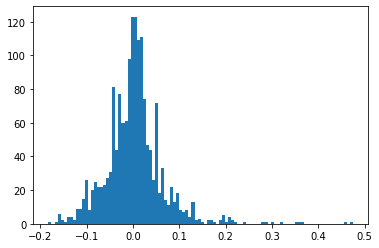

In [49]:
plt.hist(ys, bins=100)
plt.show()

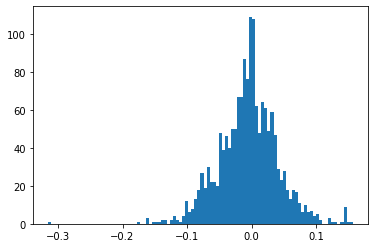

In [50]:
plt.hist(xs, bins=100)
plt.show()

In [22]:
# plt.hist(xs_reg, bins=100)
# plt.show()

In [51]:
f1 = pd.read_csv('./submission_org_reg.csv')
# f2 = pd.read_csv('./submission_org_cls.csv')

In [52]:
f1.head(5)

,ID,x,y
0,id_e7032b10,0.005130,0.065957
1,id_ae7cb51e,-0.021330,-0.000602
2,id_e59f7730,-0.021330,-0.000602
3,id_b9011c86,0.001973,0.014184
4,id_caaeb9f8,0.001973,0.014184


In [ ]:
# f1.head(5)

In [ ]:
f1.x = (f1.x + f2.x) / 2.
f1.y = (f1.y + f2.y) / 2.

In [ ]:
f1.to_csv('avg.csv', index=False)

In [ ]:
f1['Yield'].isnull().values.any()

In [ ]:
plt.scatter(f1.x, f1.y, alpha=0.5)
plt.show()

In [ ]:
plt.hist(f1.x)
plt.show()

In [ ]:
f1.x = - f1.x / 100.
f1.y = - f1.y / 100.

In [ ]:
f1.head()

In [ ]:
f1.to_csv('./submission.csv', index=False)

In [ ]:
# f2.tail()

In [ ]:
# !cp ./submission.csv ./submission3.csv